In [13]:
import pandas as pd

file_path = 'merged_data.csv'
data = pd.read_csv(file_path)
data.head()

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035


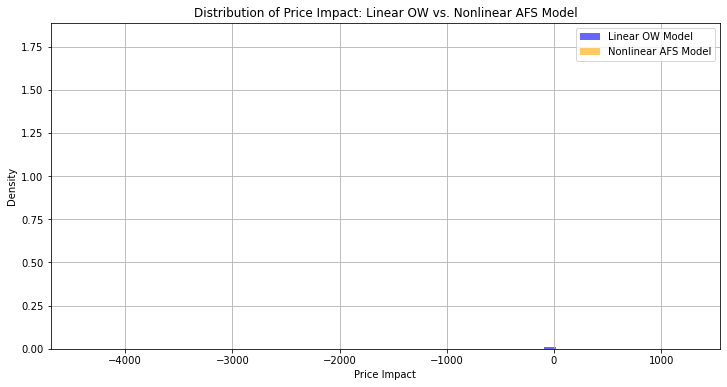

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the models
lambda_linear = 0.0035  # Parameter for the linear OW model
lambda_nonlinear = 0.0035  # Parameter for the nonlinear AFS model
p_nonlinear = 0.5  # Power for the square-root law in the nonlinear model

# Calculate price impact for Linear OW model
data['linear_impact'] = lambda_linear * data['Signed Volume']

# Calculate price impact for Nonlinear AFS model
data['nonlinear_impact'] = lambda_nonlinear * np.sign(data['Signed Volume']) * np.abs(data['Signed Volume']) ** p_nonlinear

# Plotting the distributions
plt.figure(figsize=(12, 6))
plt.hist(data['linear_impact'], bins=50, alpha=0.6, label='Linear OW Model', color='blue', density=True)
plt.hist(data['nonlinear_impact'], bins=50, alpha=0.6, label='Nonlinear AFS Model', color='orange', density=True)
plt.title('Distribution of Price Impact: Linear OW vs. Nonlinear AFS Model')
plt.xlabel('Price Impact')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Summary statistics for the calculated price impacts
linear_impact_stats = data['linear_impact'].describe()
nonlinear_impact_stats = data['nonlinear_impact'].describe()

linear_impact_stats, nonlinear_impact_stats


(count    27707.000000
 mean        -3.546903
 std         37.516809
 min      -4412.754500
 25%        -10.295250
 50%         -0.700000
 75%          3.736250
 max       1265.876500
 Name: linear_impact, dtype: float64,
 count    27707.000000
 mean        -0.037592
 std          0.217798
 min         -3.929967
 25%         -0.189825
 50%         -0.049497
 75%          0.114354
 max          2.104891
 Name: nonlinear_impact, dtype: float64)

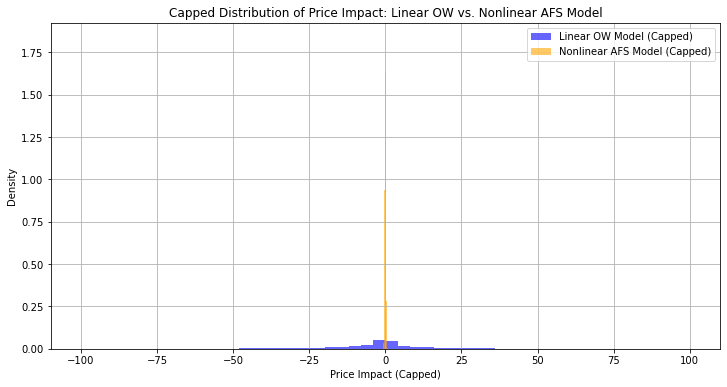

In [16]:
# Capping extreme values for better visualization
cap_threshold_linear = 100  # Cap impacts at +/- 100 for linear model
cap_threshold_nonlinear = 1  # Cap impacts at +/- 1 for nonlinear model

data['linear_impact_capped'] = np.clip(data['linear_impact'], -cap_threshold_linear, cap_threshold_linear)
data['nonlinear_impact_capped'] = np.clip(data['nonlinear_impact'], -cap_threshold_nonlinear, cap_threshold_nonlinear)

# Re-plotting the capped distributions
plt.figure(figsize=(12, 6))
plt.hist(data['linear_impact_capped'], bins=50, alpha=0.6, label='Linear OW Model (Capped)', color='blue', density=True)
plt.hist(data['nonlinear_impact_capped'], bins=50, alpha=0.6, label='Nonlinear AFS Model (Capped)', color='orange', density=True)
plt.title('Capped Distribution of Price Impact: Linear OW vs. Nonlinear AFS Model')
plt.xlabel('Price Impact (Capped)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


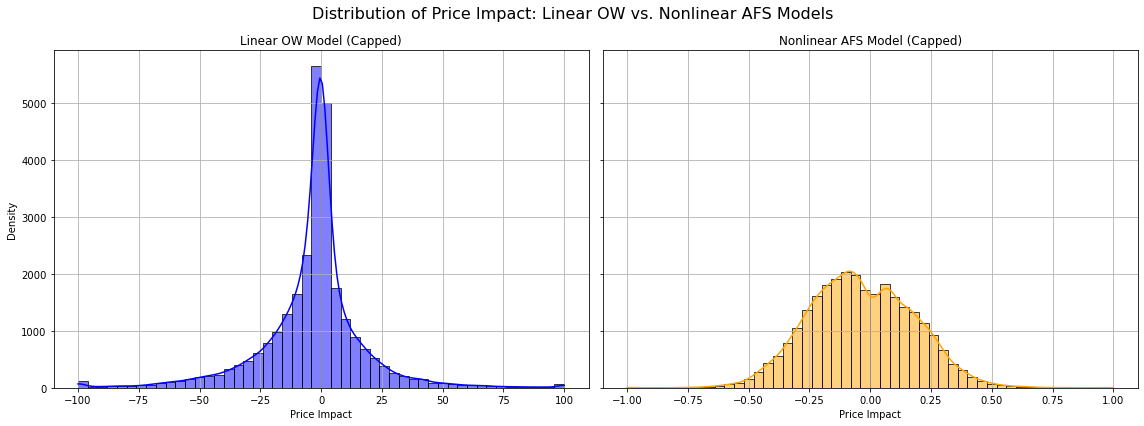

In [17]:
# Updated visualization with separate subplots and KDE curves
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Linear OW Model
sns.histplot(data['linear_impact_capped'], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Linear OW Model (Capped)')
axes[0].set_xlabel('Price Impact')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Nonlinear AFS Model
sns.histplot(data['nonlinear_impact_capped'], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Nonlinear AFS Model (Capped)')
axes[1].set_xlabel('Price Impact')
axes[1].grid(True)

plt.suptitle('Distribution of Price Impact: Linear OW vs. Nonlinear AFS Models', fontsize=16)
plt.tight_layout()
plt.show()


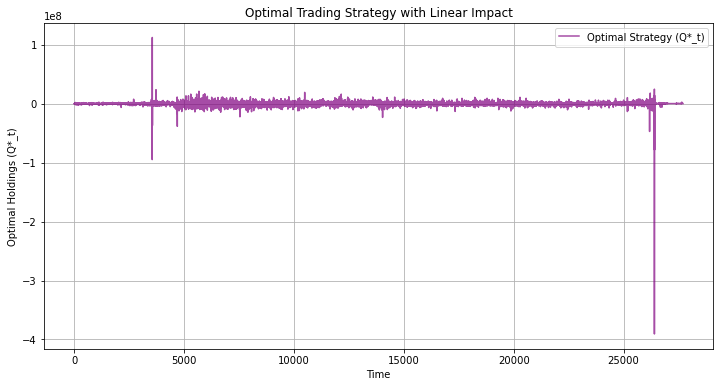

In [18]:
# Define parameters for the optimal strategy
alpha = 0.02  # Predictive signal strength
gamma = 0.5  # Risk aversion parameter
sigma = 0.01  # Volatility
lambda_linear = 0.0035  # Impact level
beta = 0.1  # Impact decay rate
phi = 0.05  # Mean reversion rate of the signal

# Compute coefficients for the optimal strategy
Cf = alpha * (1 + beta / phi) / (gamma * sigma**2) * (1 / np.sqrt(1 + (2 * lambda_linear * beta) / (gamma * sigma**2)))
CJ = np.sqrt(1 + (2 * lambda_linear * beta) / (gamma * sigma**2)) - 1

# Simulated predictive signal (f_t) and accumulated impact (J_t)
n_points = len(data)  # Number of data points in the dataset
ft = data['Signed Volume'].values  # Use Signed Volume as the predictive signal
Jt = np.cumsum(data['Signed Volume']) / len(data)  # Accumulated impact

# Calculate the optimal trading strategy Q*_t
data['optimal_strategy'] = Cf * ft - CJ * Jt

# Visualizing the strategy
plt.figure(figsize=(12, 6))
plt.plot(data['optimal_strategy'], label='Optimal Strategy (Q*_t)', color='purple', alpha=0.7)
plt.title('Optimal Trading Strategy with Linear Impact')
plt.xlabel('Time')
plt.ylabel('Optimal Holdings (Q*_t)')
plt.legend()
plt.grid(True)
plt.show()


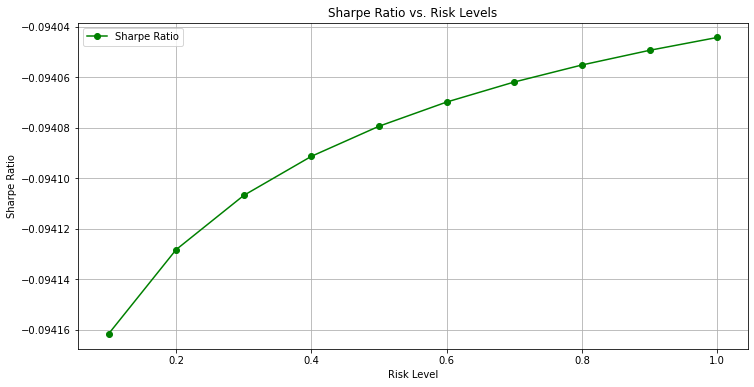

In [19]:
# Calculate Sharpe Ratios for varying risk levels
risk_levels = np.linspace(0.1, 1.0, 10) 
sharpe_ratios = []

for risk in risk_levels:
    gamma_dynamic = gamma / risk  # Adjust risk aversion parameter based on risk level
    Cf_dynamic = alpha * (1 + beta / phi) / (gamma_dynamic * sigma**2) * (1 / np.sqrt(1 + (2 * lambda_linear * beta) / (gamma_dynamic * sigma**2)))
    CJ_dynamic = np.sqrt(1 + (2 * lambda_linear * beta) / (gamma_dynamic * sigma**2)) - 1
    
    # Recalculate the strategy and its risk-adjusted return (PnL and Risk)
    strategy_dynamic = Cf_dynamic * ft - CJ_dynamic * Jt
    pnl = np.mean(strategy_dynamic)  # Simplified PnL approximation (average return)
    risk_dynamic = np.std(strategy_dynamic)  # Risk (standard deviation of returns)
    sharpe_ratio = pnl / risk_dynamic  # Sharpe Ratio
    
    sharpe_ratios.append(sharpe_ratio)

# Visualize Sharpe Ratios
plt.figure(figsize=(12, 6))
plt.plot(risk_levels, sharpe_ratios, marker='o', color='green', label='Sharpe Ratio')
plt.title('Sharpe Ratio vs. Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.legend()
plt.show()


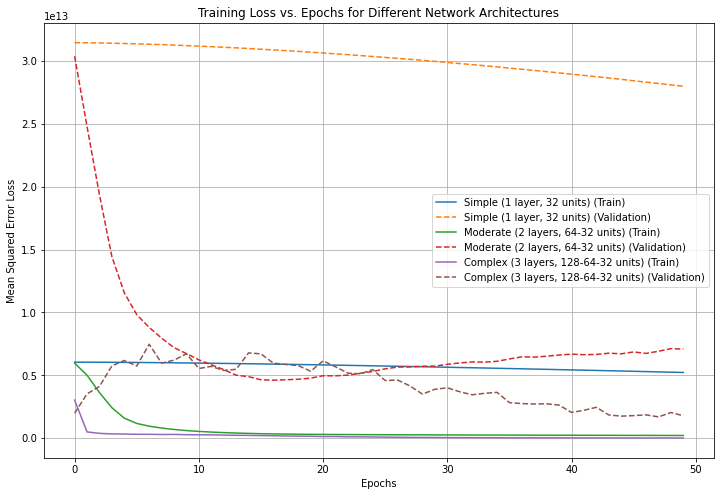

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Prepare input features and target
features = np.column_stack((ft, Jt, data['price'].values))  # Combine ft, Jt, and price as features
target = data['optimal_strategy'].values  # Use optimal strategy as the target

# Normalize features for better training performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split data into training and validation sets
split_idx = int(0.8 * len(features))
X_train, X_val = features_normalized[:split_idx], features_normalized[split_idx:]
y_train, y_val = target[:split_idx], target[split_idx:]

# Define neural network architectures
def create_model(hidden_layers):
    model = Sequential([Input(shape=(X_train.shape[1],))])
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))  # Single output (optimal strategy)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')  # Use MSE as a simple loss function
    return model

# Train and evaluate models with different architectures
architectures = {
    "Simple (1 layer, 32 units)": [32],
    "Moderate (2 layers, 64-32 units)": [64, 32],
    "Complex (3 layers, 128-64-32 units)": [128, 64, 32]
}

history_dict = {}

for name, layers in architectures.items():
    model = create_model(layers)
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=50, batch_size=64, verbose=0
    )
    history_dict[name] = history.history

# Plot training and validation loss for different architectures
plt.figure(figsize=(12, 8))
for name, history in history_dict.items():
    plt.plot(history['loss'], label=f'{name} (Train)')
    plt.plot(history['val_loss'], linestyle='--', label=f'{name} (Validation)')
plt.title('Training Loss vs. Epochs for Different Network Architectures')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show()
